In [1]:
%env JAX_PLATFORM_NAME=cpu

import jaxtyping  # noqa: F401

%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype

env: JAX_PLATFORM_NAME=cpu


In [2]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax

from tqdm.notebook import trange

from jaxtyping import Array, Bool, Float

from chaogatenn.chaogate import ChaoGate
from chaogatenn.maps import DuffingMap
from chaogatenn.utils import grad_norm

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.style.use("default")
sns.set_theme(
    context="paper",
    style="white",
    palette="tab10",
    font="serif",
    font_scale=3,
    color_codes=True,
    rc={"text.usetex": True},
)

In [4]:
# Map = LogisticMap(a=4.0)
# Map = LorenzMap(sigma=10.0, rho=28.0, beta=8 / 3, dt=0.01, steps=1000)
Map = DuffingMap(
    alpha=1.0, beta=5.0, delta=0.02, gamma=8.0, omega=0.5, dt=0.01, steps=1000
)

In [5]:
# Training data for the Half Adder
X = jnp.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=bool)  # Input combinations
y_sum = jnp.array([0, 1, 1, 0], dtype=bool)  # XOR gate output for Sum
y_carry = jnp.array([0, 0, 0, 1], dtype=bool)  # AND gate output for Carry

In [6]:
@eqx.filter_value_and_grad()
def compute_sum_loss(
    xor_gate: ChaoGate, x: Bool[Array, "batch 2"], y_sum: Bool[Array, "batch"]
) -> Float[Array, ""]:
    pred_sum = jax.vmap(xor_gate)(x)

    # Binary cross-entropy loss for XOR (Sum)
    loss_sum = -jnp.mean(
        y_sum * jnp.log(pred_sum + 1e-15) + (1 - y_sum) * jnp.log(1 - pred_sum + 1e-15)
    )

    return loss_sum

In [7]:
@eqx.filter_value_and_grad()
def compute_carry_loss(
    and_gate: ChaoGate, x: Bool[Array, "batch 2"], y_carry: Bool[Array, "batch"]
) -> Float[Array, ""]:
    pred_carry = jax.vmap(and_gate)(x)
    # Binary cross-entropy loss for AND (Carry)
    loss_carry = -jnp.mean(
        y_carry * jnp.log(pred_carry + 1e-15)
        + (1 - y_carry) * jnp.log(1 - pred_carry + 1e-15)
    )

    # Total loss is the sum of both losses
    return loss_carry

In [8]:
@eqx.filter_jit
def make_step(
    xor_gate: ChaoGate,
    and_gate: ChaoGate,
    X: Bool[Array, "batch 2"],
    y_sum: Bool[Array, "batch"],
    y_carry: Bool[Array, "batch "],
    optim: optax.GradientTransformation,
    opt_state: optax.OptState,
) -> (Float[Array, "dim"], ChaoGate, optax.OptState):  # type: ignore
    loss_sum, grads_sum = compute_sum_loss(xor_gate, X, y_sum)

    loss_carry, grads_carry = compute_carry_loss(and_gate, X, y_carry)

    loss = loss_sum + loss_carry
    updates, opt_state = optim.update([grads_sum, grads_carry], opt_state)

    xor_gate = eqx.apply_updates(xor_gate, updates[0])  # type: ignore
    and_gate = eqx.apply_updates(and_gate, updates[1])  # type: ignore
    return loss_sum, loss_carry, loss, xor_gate, and_gate, opt_state

In [9]:
# Initialize the XOR and AND gates with random values
DELTA, X0, X_THRESHOLD = jax.random.normal(jax.random.PRNGKey(0), (3, 2))

xor_gate = ChaoGate(DELTA=DELTA[0], X0=X0[0], X_THRESHOLD=X_THRESHOLD[0], Map=Map)
and_gate = ChaoGate(DELTA=DELTA[1], X0=X0[1], X_THRESHOLD=X_THRESHOLD[1], Map=Map)

In [10]:
optim = optax.adabelief(learning_rate=3e-4)
opt_state = optim.init(eqx.filter([xor_gate, and_gate], eqx.is_inexact_array))

In [11]:
epochs = 2500
loss_list = []
loss_sum_list = []
loss_carry_list = []
grad_norm_list = []
for epoch in trange(epochs):
    loss_sum, loss_carry, loss, xor_gate, and_gate, opt_state = make_step(
        xor_gate,  # type: ignore
        and_gate,  # type: ignore
        X,
        y_sum,
        y_carry,
        optim,
        opt_state,  # type: ignore
    )
    _, grads = compute_sum_loss(xor_gate, X, y_sum)
    grad_norm_value = grad_norm(grads)
    loss_list.append(loss)
    loss_sum_list.append(loss_sum)
    loss_carry_list.append(loss_carry)
    grad_norm_list.append(grad_norm_value)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, loss: {loss}, grad norm: {grad_norm_value}")

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 0, loss: 1.3971590995788574, grad norm: 1.655052661895752
Epoch 10, loss: 1.1614279747009277, grad norm: 1.6138049364089966
Epoch 20, loss: 1.147275447845459, grad norm: 1.5673677921295166
Epoch 30, loss: 1.1315593719482422, grad norm: 1.540945053100586
Epoch 40, loss: 1.1106317043304443, grad norm: 1.555091142654419
Epoch 50, loss: 1.0843344926834106, grad norm: 1.6036673784255981
Epoch 60, loss: 1.0526827573776245, grad norm: 1.6484655141830444
Epoch 70, loss: 1.0171184539794922, grad norm: 1.642109990119934
Epoch 80, loss: 0.9818786382675171, grad norm: 1.5661436319351196
Epoch 90, loss: 0.9511721730232239, grad norm: 1.4157310724258423
Epoch 100, loss: 0.9255518913269043, grad norm: 1.1935009956359863
Epoch 110, loss: 0.904612123966217, grad norm: 0.959348201751709
Epoch 120, loss: 0.8875393867492676, grad norm: 0.7790181636810303
Epoch 130, loss: 0.8731857538223267, grad norm: 0.659201979637146
Epoch 140, loss: 0.8607378005981445, grad norm: 0.5753631591796875
Epoch 150, los

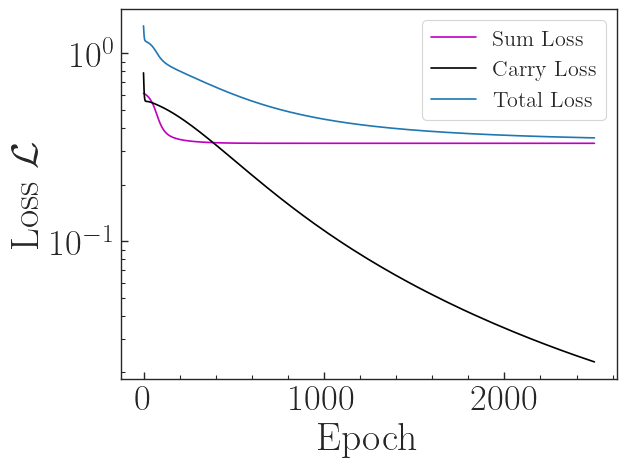

In [ ]:
# Plot the loss and gradient norm
fig, ax = plt.subplots(1, 1)
ax.plot(loss_sum_list, "m", label="Sum Loss")
ax.plot(loss_carry_list, "k", label="Carry Loss")
ax.plot(loss_list, label="Total Loss")
ax.set_xlabel("Epoch")
ax.legend(fontsize=16)
ax.set_yscale("log")
ax.set_ylabel("Loss $\\mathcal{L}$")
# ax.set_xticks([500, 1500, 2500])
ax.minorticks_on()
ax.tick_params(axis="both", which="both", direction="in", bottom=True, left=True)
plt.savefig("../figures/logistic_half_adder_curve.png", dpi=300, bbox_inches="tight")
plt.savefig("../figures/logistic_half_adder_curve.pdf", dpi=300, bbox_inches="tight")
plt.savefig("../figures/logistic_half_adder_curve.svg", dpi=300, bbox_inches="tight")

plt.show()


In [13]:
# Display trained parameters
print("\nTrained XOR Gate Parameters:")
print(
    f"DELTA: {xor_gate.DELTA}, X0: {xor_gate.X0}, X_THRESHOLD: {xor_gate.X_THRESHOLD}"
)

print("\nTrained AND Gate Parameters:")
print(
    f"DELTA: {and_gate.DELTA}, X0: {and_gate.X0}, X_THRESHOLD: {and_gate.X_THRESHOLD}"
)

# Evaluate the trained Half-Adder
print("\nHalf-Adder Evaluation:")
for i in range(len(X)):
    sum_output = xor_gate(X[i])
    carry_output = and_gate(X[i])
    print(
        f"Input: {X[i]}, Predicted Sum: {sum_output:.0f}, Predicted Carry: {carry_output:.0f}"
    )


Trained XOR Gate Parameters:
DELTA: 0.39306458830833435, X0: 0.3112305700778961, X_THRESHOLD: 0.24647212028503418

Trained AND Gate Parameters:
DELTA: -1.3150402307510376, X0: 1.2890511751174927, X_THRESHOLD: 3.418865203857422

Half-Adder Evaluation:
Input: [False False], Predicted Sum: 0, Predicted Carry: 0
Input: [False  True], Predicted Sum: 1, Predicted Carry: 0
Input: [ True False], Predicted Sum: 1, Predicted Carry: 0
Input: [ True  True], Predicted Sum: 0, Predicted Carry: 1
